In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
5 runs of 50 epochs, seed = 10, 20, 30, 40, 50; 
validation accuracies: 0.9492, 0.9457, 0.9463, 0.9439, 0.9455
"""
from __future__ import print_function, division
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

# Add src to path
import sys
sys.path.append('../src')

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 2.0.1+cu117
Torchvision Version: 0.15.2+cu117
GPU is available? True


## Read Data

In [3]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert to tensor and scale to [0, 1]
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

12.6%

100.0%


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100.0%
97.4%

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100.0%
100.0%


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [4]:
N = len(mnist_trainset)
N_test = len(mnist_testset)

x_train = torch.stack([data[0] for data in mnist_trainset][:N]).reshape(len(mnist_trainset), -1)
y_train = torch.LongTensor([data[1] for data in mnist_trainset][:N])
x_test = torch.stack([data[0] for data in mnist_testset][:N_test]).reshape(len(mnist_testset), -1)
y_test = torch.LongTensor([data[1] for data in mnist_testset][:N_test])

print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

x_train.shape: torch.Size([60000, 784])
y_train.shape: torch.Size([60000])
x_test.shape: torch.Size([10000, 784])
y_test.shape: torch.Size([10000])


## Block Coordinate Descent

In [4]:
from bcd import ThreeSplitBCD

bcd_runner = ThreeSplitBCD((x_train,y_train), (x_test,y_test), K=10, batch_size=N, device=device, seed=42)


In [5]:
results = bcd_runner.train(50)

Epoch 1 / 50 
 - time: 1.529998540878296 - sq_loss: 20155.943359375 - tot_loss: 20183.39351656154 - acc: 0.5362333333333333 - val_acc: 0.5339
Epoch 2 / 50 
 - time: 1.2384991645812988 - sq_loss: 15222.6513671875 - tot_loss: 15233.624267286039 - acc: 0.7958666666666666 - val_acc: 0.7999
Epoch 3 / 50 
 - time: 1.2409992218017578 - sq_loss: 11700.11328125 - tot_loss: 11706.48508812394 - acc: 0.8704666666666667 - val_acc: 0.874
Epoch 4 / 50 
 - time: 1.2354998588562012 - sq_loss: 9050.5791015625 - tot_loss: 9056.469013912603 - acc: 0.897 - val_acc: 0.9
Epoch 5 / 50 
 - time: 1.2394990921020508 - sq_loss: 7016.130859375 - tot_loss: 7021.46170763718 - acc: 0.9095166666666666 - val_acc: 0.9117
Epoch 6 / 50 
 - time: 1.2308404445648193 - sq_loss: 5442.48583984375 - tot_loss: 5447.834357704967 - acc: 0.9169833333333334 - val_acc: 0.9184
Epoch 7 / 50 
 - time: 1.232499361038208 - sq_loss: 4222.26611328125 - tot_loss: 4227.073806764558 - acc: 0.9227666666666666 - val_acc: 0.9234
Epoch 8 / 50 
 - 

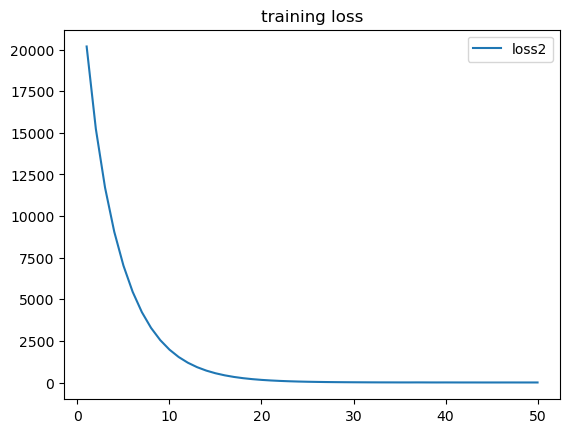

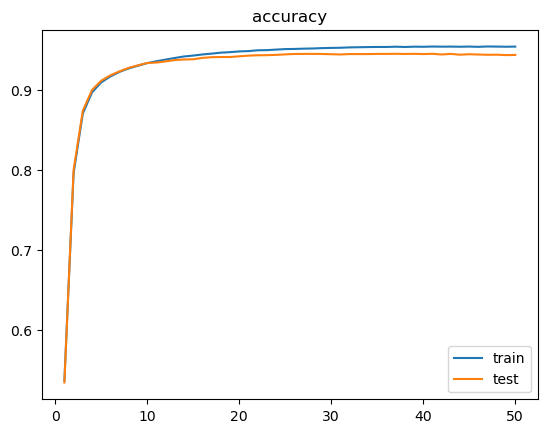

In [8]:
# retrieve results
loss1, loss2 = results['loss1'], results['loss2']
accuracy_train, accuracy_test = results['acc_tr'], results['acc_te']

niter=len(loss1)

plt.figure()
plt.plot(np.arange(1,niter+1), loss2, label='loss2')
plt.title('training loss')
plt.legend()

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_train, label='train')
plt.plot(np.arange(1,niter+1), accuracy_test, label='test')
plt.title('accuracy')
plt.legend()
plt.show()

## Gradient Descent

In [5]:
from torch.optim import SGD, Adam
from gd import GDStandard

gd_runner = GDStandard((x_train,y_train), (x_test,y_test), K=10, batch_size=64, OptimClass=Adam, lr=3e-4, device=device, seed=42)
results_adam = gd_runner.train(50)
save_path = '../results/adam_b64_lr3e-4.json'
# Save results
with open(save_path, 'w') as f:
    json.dump(results_adam, f)

Epoch 1/50: Train Loss: 0.0342, Train Acc: 0.7231, Test Loss: 0.0341, Test Acc: 0.8042
Epoch 2/50: Train Loss: 0.0339, Train Acc: 0.8149, Test Loss: 0.0340, Test Acc: 0.8422
Epoch 3/50: Train Loss: 0.0339, Train Acc: 0.8455, Test Loss: 0.0340, Test Acc: 0.8698
Epoch 4/50: Train Loss: 0.0339, Train Acc: 0.8641, Test Loss: 0.0340, Test Acc: 0.8804
Epoch 5/50: Train Loss: 0.0339, Train Acc: 0.8770, Test Loss: 0.0340, Test Acc: 0.8937
Epoch 6/50: Train Loss: 0.0339, Train Acc: 0.8861, Test Loss: 0.0340, Test Acc: 0.8994
Epoch 7/50: Train Loss: 0.0339, Train Acc: 0.8948, Test Loss: 0.0340, Test Acc: 0.9042
Epoch 8/50: Train Loss: 0.0339, Train Acc: 0.9010, Test Loss: 0.0340, Test Acc: 0.9095
Epoch 9/50: Train Loss: 0.0339, Train Acc: 0.9047, Test Loss: 0.0340, Test Acc: 0.9121
Epoch 10/50: Train Loss: 0.0339, Train Acc: 0.9087, Test Loss: 0.0340, Test Acc: 0.9085
Epoch 11/50: Train Loss: 0.0339, Train Acc: 0.9141, Test Loss: 0.0340, Test Acc: 0.9227
Epoch 12/50: Train Loss: 0.0338, Train Ac

FileNotFoundError: [Errno 2] No such file or directory: '../results/adam_b64_lr3e-4.json'

In [14]:
from torch.optim import SGD

optim_args = {'lr': 1e-1, 'momentum': 0.9}
gd_runner = GDStandard((x_train,y_train), (x_test,y_test), K=10, batch_size=64, OptimClass=SGD, optim_args=optim_args, device=device, seed=42)
results_momentum = gd_runner.train(50)
save_path = '../results/momentum9_b64_lr1e-1.json'
# Save results
with open(save_path, 'w') as f:
    json.dump(results_momentum, f)

Epoch 1/50: Train Loss: 0.0355, Train Acc: 0.4341, Test Loss: 0.0343, Test Acc: 0.6291
Epoch 2/50: Train Loss: 0.0340, Train Acc: 0.7456, Test Loss: 0.0341, Test Acc: 0.7937
Epoch 3/50: Train Loss: 0.0339, Train Acc: 0.8137, Test Loss: 0.0340, Test Acc: 0.8410
Epoch 4/50: Train Loss: 0.0339, Train Acc: 0.8387, Test Loss: 0.0340, Test Acc: 0.8556
Epoch 5/50: Train Loss: 0.0339, Train Acc: 0.8586, Test Loss: 0.0340, Test Acc: 0.8735
Epoch 6/50: Train Loss: 0.0339, Train Acc: 0.8700, Test Loss: 0.0340, Test Acc: 0.8861
Epoch 7/50: Train Loss: 0.0339, Train Acc: 0.8817, Test Loss: 0.0340, Test Acc: 0.8899
Epoch 8/50: Train Loss: 0.0339, Train Acc: 0.8863, Test Loss: 0.0340, Test Acc: 0.8964
Epoch 9/50: Train Loss: 0.0339, Train Acc: 0.8931, Test Loss: 0.0340, Test Acc: 0.8930
Epoch 10/50: Train Loss: 0.0339, Train Acc: 0.8969, Test Loss: 0.0340, Test Acc: 0.9039
Epoch 11/50: Train Loss: 0.0339, Train Acc: 0.8998, Test Loss: 0.0340, Test Acc: 0.9069
Epoch 12/50: Train Loss: 0.0339, Train Ac

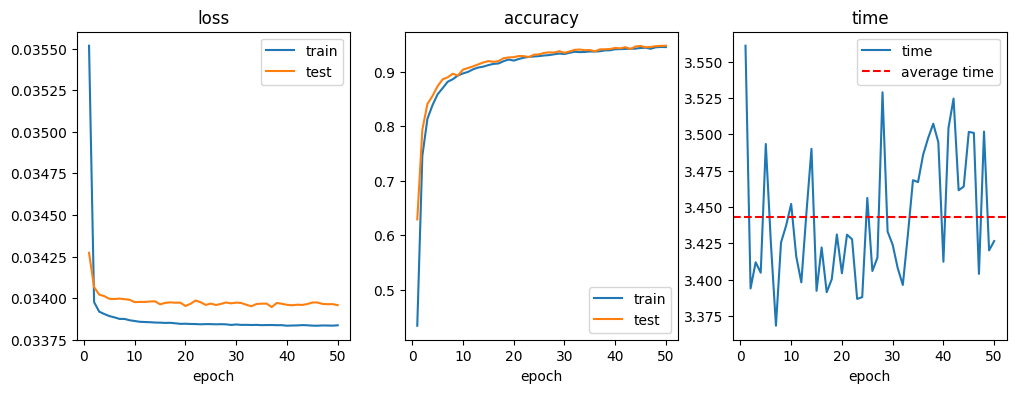

In [15]:
from utils import plot_results

plot_results(results_momentum)
plt.show()

### RMSprop

In [17]:
from torch.optim import RMSprop

optim_args = {'lr': 1e-3}
gd_runner = GDStandard((x_train,y_train), (x_test,y_test), K=10, batch_size=64, OptimClass=RMSprop, optim_args=optim_args, device=device, seed=42)
results = gd_runner.train(50)
save_path = '../results/RMSprop_b64_lr1e-3.json'
# Save results
with open(save_path, 'w') as f:
    json.dump(results, f)

Epoch 1/50: Train Loss: 0.0340, Train Acc: 0.7820, Test Loss: 0.0340, Test Acc: 0.8405
Epoch 2/50: Train Loss: 0.0339, Train Acc: 0.8672, Test Loss: 0.0340, Test Acc: 0.8937
Epoch 3/50: Train Loss: 0.0339, Train Acc: 0.8950, Test Loss: 0.0340, Test Acc: 0.9040
Epoch 4/50: Train Loss: 0.0339, Train Acc: 0.9088, Test Loss: 0.0340, Test Acc: 0.9196
Epoch 5/50: Train Loss: 0.0338, Train Acc: 0.9182, Test Loss: 0.0340, Test Acc: 0.9259
Epoch 6/50: Train Loss: 0.0338, Train Acc: 0.9234, Test Loss: 0.0340, Test Acc: 0.9326
Epoch 7/50: Train Loss: 0.0338, Train Acc: 0.9300, Test Loss: 0.0340, Test Acc: 0.9284
Epoch 8/50: Train Loss: 0.0338, Train Acc: 0.9322, Test Loss: 0.0340, Test Acc: 0.9377
Epoch 9/50: Train Loss: 0.0338, Train Acc: 0.9365, Test Loss: 0.0340, Test Acc: 0.9409
Epoch 10/50: Train Loss: 0.0338, Train Acc: 0.9405, Test Loss: 0.0340, Test Acc: 0.9365
Epoch 11/50: Train Loss: 0.0338, Train Acc: 0.9437, Test Loss: 0.0340, Test Acc: 0.9419
Epoch 12/50: Train Loss: 0.0338, Train Ac

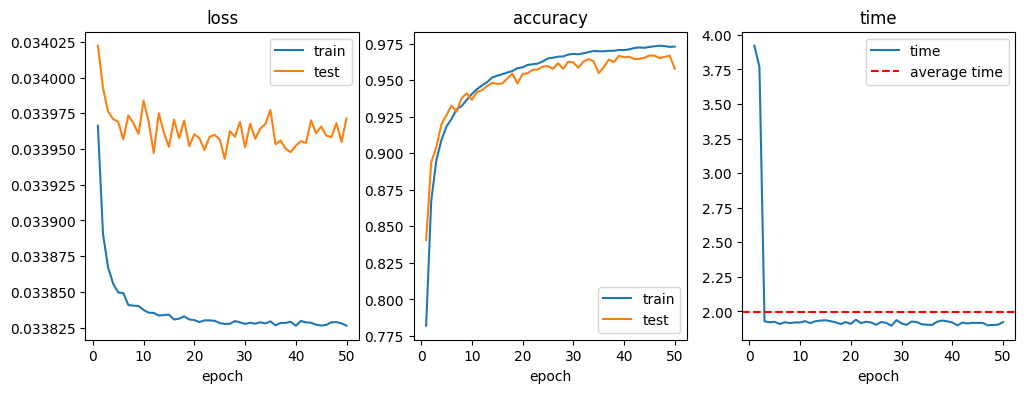

In [18]:
plot_results(results)
plt.show()